In [ ]:
"""
Generative End to End Model for "Wizard Of Wikipedia" task based on Dinan et al. Wizard Of Wikipedia: Knowledge
Powered Conversational Agents.

Deepak Goyal <deepak.16je002137@ece.iitism.ac.in>

"""

In [ ]:
"""
This code takes inspiration from the following sources:

The Annotated Transformer : http://nlp.seas.harvard.edu/2018/04/03/attention.html
Illustrated Transformer   : http://jalammar.github.io/illustrated-transformer/
Samuel Lynn Evans's Blog  : https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
Tensorflow's Medium Blog  : https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2
Pytorch's Chatbot Tutorial: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

"""

In [1]:
# Framework for running model on GPU
import torch
import torch.nn as nn
import torch.nn.functional as F

# For Visualising gradient flow across the model
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# For Visualising training loss, accuracy Vs epochs
from visdom import Visdom

# Basic computation library needed for visdom visualising class
import numpy as np

# Other libraries for data loading, processing etc
import json
import os
import re
import math
import copy
import os
import string
import time

In [2]:
# Specify which machine you are running things
running_device='local'

In [3]:
def raw_data_loader(running_device):
    """ 
        Function for loading json data into a list
    """
    
    file_dir=''
    file_name='data.json'
    if running_device=='local':
        file_dir='/home/naive/Documents/rohit/Wizard Of Wikipedia/Dataset'
    elif running_device=='colab':
        file_dir='/content/drive/My Drive/Data/Wizard of Wikipedia'
    else:
        print("Invalid running device")
        return
    
    data=os.path.join(file_dir,file_name)
    
    json_data=None
    with open(data) as f:
        json_data=json.load(f)
    
    return json_data

In [4]:
json_data=None

print("Loading Raw Data into a list....")

t1=time.time()
json_data=raw_data_loader(running_device)
t2=time.time()

print("Loading raw data took "+str(t2-t1)+" seconds")

Loading Raw Data into a list....
Loading raw data took 12.674209594726562 seconds


In [5]:
class vocabulary:
    """ Creates vocabulary for our corpus data of conversations"""
    
    def __init__(self):
        """
            self.word2Index(Dictionary): Maps words to tokens
            self.num_words(Scalar)     : Number of distinct words in the vocabulary
            
        """
        
        self.word2Index={'PAD':0,"<START>":1,"<END>":2}
        self.num_words=3
        
    def addSentence(self,sentence):
        """ 
            Adds sentences into vocabulary by splitting them
        """
        
        for word in sentence.split(" "):
            self.addWord(word)
    
    def addWord(self,word):
        
        if word not in self.word2Index.keys():
            self.word2Index[word]=self.num_words
            self.num_words+=1       

In [6]:
# Preprocessing functions for the data

def remove_punctuation(sentence):
    # thanks to https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    return sentence.translate(str.maketrans('', '', string.punctuation)).lower().strip()


In [7]:
def load_data(data_json):
    
    context, knowledge, wizard=[],[],[]
    dict2cnt={}
    count=0
    
    N=len(data_json)
    for id in range(N):
        
        current_knowledge,current_wizard,context_knowledge,previous_context=[],[],[],[]
        tmp_context=[]
        
        current_conv=data_json[id]
        
        topic_chosen=remove_punctuation(current_conv['chosen_topic'])
        tmp_context.append(topic_chosen)
        
        conversation_length=len(current_conv['dialog'])
        
        for i in range(conversation_length):
            
            if current_conv['dialog'][i]['speaker']=='0_Wizard':
                
                dict2cnt[count]=len(current_conv['dialog'][i]['retrieved_passages'])
                count=count+1
                
                for x in range(len(current_conv['dialog'][i]['retrieved_passages'])):
                    
                    idx=current_conv['dialog'][i]['retrieved_passages'][x]
                    
                    for value in idx.values():
                        
                        for j in range(len(value)):
                            value[j]=remove_punctuation(value[j])
                            
                        current_knowledge.append(value)
                
                wizard_dialog=remove_punctuation(current_conv['dialog'][i]['text'])
                
                current_wizard.append(wizard_dialog)
                tmp_context.append(wizard_dialog)
            
            else:
                apperentice_dialog=remove_punctuation(current_conv['dialog'][i]['text'])
                tmp_context.append(apperentice_dialog)
                
        knowledge.append(current_knowledge)
        wizard.append(current_wizard)
        
        final_context=[]
        flag=True
        
        if current_conv['dialog'][0]['speaker']=='0_Wizard':
            flag=False
        
        for i in range(len(tmp_context)):
            temp=[]
            
            for j in range(i+1):
                temp.append(tmp_context[j])
                
            if flag:
                if i%2!=0 and len(final_context)<len(current_wizard):
                    final_context.append(temp)
                    
            else:
                if i%2==0 and len(final_context)<len(current_wizard):
                    final_context.append(temp)
        
        context.append(final_context)
    
    return context, knowledge, wizard, dict2cnt

print("Getting 22311 conversation's context, knowledge, wizard utterances..")
t1=time.time()
context, knowledge, wizard, dict2cnt=load_data(json_data)        
t2=time.time()
print("This took: "+str(t2-t1)+" seconds")
                

Getting 22311 conversation's context, knowledge, wizard utterances..
This took: 10.345833778381348 seconds


In [8]:
def after_load_process(context,knowledge,wizard):
    input_context=[]
    input_knowledge=[]
    output_wizard=[]
    for i in range(len(wizard)):
        for c in context[i]:
            input_context.append(c)
        for k in knowledge[i]:
            input_knowledge.append(k)
        for w in wizard[i]:
            output_wizard.append(w)

    input_knowledge2=[]
    index=0
    for i in range(50246):
        r=dict2cnt[i]
        tmp=[]
        fr=index
        to=index+r
        for j in range(fr,to):
            tmp.append(input_knowledge[index])
            index=index+1
        input_knowledge2.append(tmp)
    input_knowledge3=[]
    for i in range(len(input_knowledge2)):
        g=[]
        for j in range(len(input_knowledge2[i])):
            s=""
            for k in range(len(input_knowledge2[i][j])):
                s=s+" "+input_knowledge2[i][j][k]
            s=s.strip()
            g.append(s)
        input_knowledge3.append(g)
    return input_context,input_knowledge3,output_wizard

print("Converting the extracted sentences into lists...")
t1=time.time()
final_context, final_knowledge, final_wizard=after_load_process(context,knowledge,wizard)
t2=time.time()
print("This took: "+str(t2-t1)+" seconds")
    


Converting the extracted sentences into lists...
This took: 2.740953207015991 seconds


In [9]:
##############################Sentence Length Analysis#############################

avg_wizard=0.0
no_wizard=0
no_knowledge=0
no_context=0
for i in range(len(final_wizard)):
    avg_wizard+=len(final_wizard[i].split())
    no_wizard+=1
    
avg_context=0.0
for i in range(len(final_context)):
    for j in range(len(final_context[i])):
        avg_context+=len(final_context[i][j].split())
        no_context+=1
        
avg_knowledge=0.0

for i in range(len(final_knowledge)):
    for j in range(len(final_knowledge[i])):
        avg_knowledge+=len(final_knowledge[i][j].split())
        no_knowledge+=1
        
avg_sentence=(avg_knowledge+avg_wizard+avg_context)/(no_wizard+no_context+no_knowledge)
print("Average Sentence Length: "+str(avg_sentence))
avg_wizard=avg_wizard/len(final_wizard)
avg_context=avg_context/no_context
avg_knowledge=avg_knowledge/no_knowledge
print("Average wizard's sentence length: "+str(avg_wizard))
print("Average knowledge's sentence length: "+str(avg_knowledge))
print("Average context's sentence length: "+str(avg_context))



634156
43811418.0
69.08618384119995
18.304860088365242
113.25242616631711
12.696140032022155
48.0844754289015


In [10]:
max_length=70

def process(sentence):
    """
        Preprocessing sentencing to make them of equal length and appending and terminating them with
        start (<START>) and end (<END>) token.
        
    """
    
    
    words=sentence.split()
    sentence_length=max_length-2
    if len(words)<=sentence_length:
        for i in range(sentence_length-len(words)):
            words.append("PAD")
    else:
        words=words[:sentence_length]
    
    res=""
    words.append("<END>")
    words.insert(0,"<START>")
    assert len(words)==max_length
    for w in words:
        res=res+" "+w
    res=res.strip()
    return res

In [11]:
vocab=vocabulary()

def process_loaded(input_context,input_knowledge,output_wizard):
    """ Processing sentences and forming vocabulary
    """
    
    for i in range(len(output_wizard)):
        output_wizard[i]=process(output_wizard[i])
        vocab.addSentence(output_wizard[i])
        assert len(output_wizard[i].split())==max_length
    
    for i in range(len(input_knowledge)):
        for j in range(len(input_knowledge[i])):
            input_knowledge[i][j]=process(input_knowledge[i][j])
            vocab.addSentence(input_knowledge[i][j])
            assert len(input_knowledge[i][j].split())==max_length
        
    for i in range(len(input_context)):
        for j in range(len(input_context[i])):
            input_context[i][j]=process(input_context[i][j])
            vocab.addSentence(input_context[i][j])
            assert len(input_context[i][j].split())==max_length
    return input_context, input_knowledge, output_wizard

print("Processing fetched sentences...")
t1=time.time()
p_context,p_knowledge,p_wizard=process_loaded(final_context,final_knowledge,final_wizard)
t2=time.time()
print("This process took: "+str(t2-t1))

Processing fetched sentences...
This process took: 25.054928302764893


In [12]:
##########################SANITY CHECK##########################

assert len(p_wizard)==50246
assert len(p_context)==50246
assert len(p_knowledge)==50246

print("Running Sanity Checks on the data...")

t1=time.time()

for i in range(len(p_wizard)):
    assert len(p_wizard[i].split())==max_length
    
for i in range(len(p_context)):
    for j in range(len(p_context[i])):
        assert len(p_context[i][j].split())==max_length
        
for i in range(len(p_knowledge)):
    for j in range(len(p_knowledge[i])):
        assert len(p_knowledge[i][j].split())==max_length

t2=time.time()
print("Everything seems fine.")        
print("Sanity Checks took: "+str(t2-t1)+" seconds")
 
################################################################

Running Sanity Checks on the data...
Everything seems fine.
Sanity Checks took: 2.0472543239593506 seconds


In [13]:
# For Visualising training loss per epochs etc

from visdom import Visdom

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

In [14]:
device=torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [15]:
class Embeddings(nn.Module):
    """ Embeddings class for creating pretrained embeddings for word's token
    """
    def __init__(self, d_model, vocab_size,max_length):
        """ Class for converting sentence into matrix of word embeddings plus the positional encoding.
            
            Inputs: 
                d_model(scalar)   : The size of encoding desired in the model.
                vocab_size(scalar): Size of the vocabulary of the model.
                max_length(scalar): Length of the sentences.
                
            Layers:
                self.embed: Embedding layer to convert tokens into embeddings.
                self.pe   : Positional Encoder encoding word's position in the sentence.
        """
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe=PositionalEncoder(d_model,max_length)
        
    def forward(self, x):
        """ self.embed takes in the tokens associated with the words in the sentence for encoding into
            the embeddings.
            Input:
                x: Vector representing sentence. x[i] is the token of word at ith position of sentence.
                   size: (sentence_length,)
            Output:
                y: Matrix representing each word in the sentence with its encoding of size d_model plus
                   its positional encoding.
                   size: (sentence_length,d_model)
        """
        y=torch.zeros(x.size()[0],512)
        for i in range(x.size()[0]):
            y[i,:]=self.embed(x[i])
        y=self.pe(y)
        
        return y

In [16]:
class PositionalEncoder(nn.Module):
    """ To encode the position of a particular word in the sentence, Positional Encoder adds 
        something to each embedding position of a word wrt to its position in the sentence.
    """
    def __init__(self,d_model,max_length=200):
        """ 
            Input:
                d_model(scalar)        : The word embedding size of the model.
                max_length(scalar)     : The sentence length.
                
            Layers:
                self.pe: A tensor containing the values to be added to each word embedding that depends on 
                         the position of the word in the sentence.
                         Good Explanation: https://datascience.stackexchange.com/questions/51065/what-is-positional-encoding-in-transformer-model?rq=1
        """
        super().__init__()
        self.d_model=d_model
        self.pe=torch.zeros(max_length,d_model,requires_grad=False,device=device)
        for pos in range(max_length):
            for i in range(0,d_model,2):
                self.pe[pos,i]=\
                math.sin(pos/(10000**((2*i)/d_model)))
                self.pe[pos,i+1]=\
                math.cos(pos/(10000**((2*(i+1))/d_model)))
        
    def forward(self,x):
        """
            Input:
                x: Matrix representation of sentence.
                   size: sentence_length*d_model
            Output:
                x: Positional Encoded sentence.
                   size: sentence_length*d_model
        """
        
        x=x*math.sqrt(self.d_model) # makes embeddings larger by multiplying with d_model
        x=x+self.pe                 # here x represents the sentence of dimensions max_length*d_model
        return x

In [17]:
def attention(q,k,v,d_k,mask=None,dropout=None):
    """ Computes the self attention for the key query and value given
    """
    scores=torch.zeros(q.size()[0],q.size()[1],q.size()[1])
    output=torch.zeros(q.size()[0],q.size()[1],q.size()[2])
    
    for i in range(q.size()[0]):
        scores[i,:,:]=(torch.matmul(q[i,:,:],k[i,:,:].t())/math.sqrt(d_k))
        
    if mask is not None:
        for i in range(q.size()[0]):
            scores[i,:,:]=scores[i,:,:].masked_fill(mask==0,-1e9)
     
    non=nn.Softmax(dim=-1)
    for i in range(q.size()[0]):
        scores[i,:,:]=non(scores[i,:,:].clone())
    
    if dropout is not None:
        scores = dropout(scores)
        
    for i in range(q.size()[0]):
        output[i,:,:]=torch.matmul(scores[i,:,:],v[i,:,:])
        
    return output

In [18]:
class MultiHeadAttention(nn.Module):
    """ Calculates Multihead attention as described in the "Attention is all you need"
        For more details checkout: http://jalammar.github.io/illustrated-transformer/
    """
    def __init__(self, heads, d_model, dropout = 0.1):
        """ 
            Inputs:
                heads(scalar)  : Number of heads to split the d_model.
                d_model(scalar): Size of the word embeddings used in the model
                dropout(scalar): Probability for dropout layers
            
            Layers:
                self.q_linear: Linear layer for queries
                self.v_linear: Linear layer for values
                self.k_linear: Linear layer for keys
                self.dropout : Dropout layer  
                
        """
        super().__init__()
        
        assert d_model%heads==0
        
        self.d_model = d_model
        self.d_k = d_model// heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v,mask=None):
        """
            Inputs:
                q   : Query matrix for self attention
                      size: (sentence_length,d_model)
                k   : Key matrix for self attention
                      size: (sentence_length,d_model)
                v   : Value matrix for self attention
                      size: (sentence_length,d_model)
                mask: to make model blind for ahead words used in decoder
                      size: (sentence_length,sentence_length)
                      
             Outputs:
                 output: The final output of the multi head attention as described in 
                         "Attention is all you need"
                         size: (sentence_length,d_model)
        """
        
        bs = q.size(0)      
        
        k = self.k_linear(k).view(self.h,bs,self.d_k)
        q = self.q_linear(q).view(self.h,bs,self.d_k)
        v = self.v_linear(v).view(self.h,bs,self.d_k)
                
        scores = attention(q, k, v, self.d_k,mask,self.dropout)
        
        concat = scores.transpose(0,1).contiguous()\
        .view(bs,self.d_model)
        
        output = self.out(concat)

        return output

In [19]:
class FeedForward(nn.Module):
    """ FeedForward class consist of two linear layer.
    """
    def __init__(self,d_model,d_ff=2048,dropout=0.1):
        """
            Input:
                d_model(scalar): Model's embedding size
                d_ff(scalar)   : First Linear layer output neurons
                dropout(scalar): Dropout probability for dropout layer
            
            Layers:
                self.linear1: First linear layer
                self.dropout: Dropout layer (A simple way to prevent overfitting by Srivastava et al)
                              http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
                self.linear2: Second linear layer
        """
        super().__init__()
        
        self.linear1=nn.Linear(d_model,d_ff)
        self.dropout=nn.Dropout(dropout)
        self.linear2=nn.Linear(d_ff,d_model)
        
    def forward(self,x):
        """
            Input:
                x: Output of the multihead attention plus the residual
                   size: (sentence_length,d_model)
                   
            Output:
                x: Output of the two linear layer with relu in between as the non linearity
                   size: (sentence_length,d_model)
        """
        x=self.dropout(F.relu(self.linear1(x)))
        x=self.linear2(x)
        return x

In [20]:
class Encoder(nn.Module):
    """Encoder Module of the Transformer Model"""
    def __init__(self,d_model,d_ff,dropout,h):
        """
            Inputs: 
                d_model(scalar): The size of the word embedding for the model.
                d_ff(scalar)   : The size of the output neurons of the first linear in feed forward layer.
                dropout(scalar): The probability for the dropout layer
                h(scalar)      : Number of heads to split the incoming data. Make sure d_model%h==0
            
            Layers:
                self.mha       : The multihead attention sublayer of the encoder
                self.ff        : Feed Forward sublayer of the encoder 
                self.dropout1  : Dropout layer for the output of multiheadattention layer
                self.dropout2  : Dropout layer for the output of feedforward layer
        """
        
        
        super().__init__()
        
        self.mha=MultiHeadAttention(h,d_model,dropout)
        self.ff=FeedForward(d_model,d_ff,dropout)
        self.dropout1=nn.Dropout(dropout)
        self.dropout2=nn.Dropout(dropout)
        
    def forward(self,y,mask):
        """
            Inputs:
                y   : The matrix representing the input sentence into the encoder
                      size: (max_length,d_model)
                mask: The matrix for masking the model to not see ahead in decoder
                      size: None in case of encoder
                      
            Output:
                y   : The output of the multihead attention and residual layer --> Feedforward plus 
                      the residual.
                      size: (max_length,d_model)
        """
        y=self.dropout1(self.mha(y,y,y,mask))+y
        return self.dropout2(self.ff(y))+y

In [21]:
class Decoder(nn.Module):
    """ The Decoder Module of the Transformer Model"""
    def __init__(self,d_model,d_ff,dropout,h):
        """
            Input:
                d_model(scalar): The size of the word embedding for the model.
                d_ff(scalar)   : The number of output neurons in the first linear layer of 
                                 feed forward sublayer
                droput(scalar) : The dropout probability of the dropout layer
                h(scalar)      : Number of heads in the multihead attention layer
            
            Layers:
                self.dropout1  : Dropout layer for the output of first multihead attention layer
                self.dropout2  : Dropout layer for the output of second multihead attention layer
                self.dropout3  : Dropout layer for the output of feedforward layer
                
                self.mha1      : Multi head attention layer for the decoder outputs
                self.mha2      : Multi head attention layer for the encoder outputs 
                
                self.ff        : Feed Forward layer of the decoder
        """
        
        super().__init__()
        
        self.dropout1=nn.Dropout(dropout)
        self.dropout2=nn.Dropout(dropout)
        self.dropout3=nn.Dropout(dropout)
        
        self.mha1=MultiHeadAttention(h,d_model,dropout)
        self.mha2=MultiHeadAttention(h,d_model,dropout)
        self.ff=FeedForward(d_model,d_ff,dropout)
        
    def forward(self,x,y,src_mask,tgt_mask): # x is the decoder output, y is the the encoder output
        """
            Inputs:
                x       : Decoder output in testing phase and true output masked in case of
                          training (fed in first mha layer)
                          size: (sentence_length,d_model)
                y       : Encoder layer output (fed in second mha layer)
                          size: (sentence_length,d_model)
                src_mask: Mask for encoder outputs
                          size: None
                tgt_mask: Mask for decoder outputs
                          size: (sentence_length,sentence_length)
                          
            Output:
                x       : Output of the three sublayer of the decoder
                          size: (sentence_length,d_model)
        """
        
        x=x+self.dropout1(self.mha1(x,x,x,tgt_mask))
        x=x+self.dropout2(self.mha2(y,y,y,src_mask))
        x=x+self.dropout3(self.ff(x))
        return x

In [32]:
class EndtoEnd(nn.Module):
    """ Combining all layers defined above for our model
    """
    def __init__(self,d_model,d_ff,dropout,h,vocab_size,max_length):
        """
            Inputs:
                d_model(scalar)   : The size of the word embeddings of the model
                d_ff(scalar)      : The number of neurons in the output of the first linear layer 
                                    of the feedforward layer
                dropout(scalar)   : The probability of the dropout layer
                h(scalar)         : The number of the heads in multihead attention layer
                vocab_size(scalar): Size of the vocabulary of our dataset
                max_length(scalar): The fixed length of the sentence
                
            Layers:
                self.embed        : This layer converts tokens of the sentence into corresponding
                                    embeddings and adds the corresponding positional encodings  
                self.encoderLayer : The encoder layer of the model
                self.decoderLayer : The decoder layer of the model
                self.out          : Final linear layer
        """
        
        super().__init__()
        self.embed=Embeddings(d_model,vocab_size,max_length)
        self.embed.embed.weight.requires_grad=False
        self.encoderLayer=Encoder(d_model,d_ff,dropout,h)
        self.decoderLayer=Decoder(d_model,d_ff,dropout,h)
        self.d_model=d_model
        self.out=nn.Linear(d_model,vocab_size)
        
    def forward(self,x,k,src_mask,trg,trg_mask):
        """ 
            Inputs:
                x       : The context of the conversation so far.
                          size: (number of sentences(context),sentence_length,d_model)
                k       : The Knowledge sentences of that turn.
                          size: (number of sentences(knolwedge),sentence_length,d_model)
                src_mask: The encoder mask
                          size: None
                trg     : The target of the turn
                          size: (sentence_length,d_model)  
                trg_mask: Mask for making decoder blind to look ahead in the trg
                          size: (sentence_length,sentence_length)
            
            Output:
                output  : The output of the whole model. Contains probability of each word.
                          size: (sentence_length,vocab_size)
            
        """
        
        
        
        X=torch.zeros(x.size()[0],max_length*self.d_model)
        K=torch.zeros(k.size()[0],max_length*self.d_model)
        
        for i in range(x.size()[0]):
            X[i,:]=self.encoderLayer(self.embed(x[i,:]),src_mask).view(-1)
        
        for i in range(k.size()[0]):
            K[i,:]=self.encoderLayer(self.embed(k[i,:]),src_mask).view(-1)
        
        Y=X.matmul(K.t())
        Y=F.softmax(Y,dim=-1)
        
        Y_f=X+Y.matmul(K)
        
        enc_output=torch.zeros(1,max_length*self.d_model)
        
        for i in range(Y_f.size()[0]):
            enc_output=enc_output+Y_f[i,:]  # enc_output is of size max_length*self.d_model
            
        em_trg=torch.zeros(trg.size()[0],self.d_model)
        em_trg=self.embed(trg)
        
        
        enc_output=enc_output.view(max_length,-1)
        dec_output=self.decoderLayer(em_trg,enc_output,src_mask,trg_mask)
        output=self.out(dec_output)
        
        return output
        

In [33]:
def embed(s):
    
    """ Converting sentences into a list of tokens
    """
    i=0
    wordList=s.split()
    
    assert len(wordList)==max_length
    
    res=torch.zeros(len(wordList))
    
    for w in wordList:
        idx=vocab.word2Index[w]
        res[i]=idx
        i=i+1
    return res
    

In [25]:
def make_mask(x_l,y_l):
    """ 
        Constructing masks for decoder layers
    """
    res=torch.zeros(x_l,y_l)
    for i in range(x_l):
        for j in range(i+1):
            res[i,j]=1

In [26]:
def calculate(true,predicted):
    """
         Calculating F1 score (Unigram F1)
    """
    score=0
    for w in predicted:
        if w in true:
            score=score+1
    score=score/len(true)
    return score

In [27]:
def cal_ppl(prob):
    """
        Calculating Perplexity(PPL) as per: https://www.youtube.com/watch?v=NCyCkgMLRiY&t=11s
    """
    prob=prob.div(10000)
    m=nn.Sigmoid()
    prob_score=torch.zeros(prob.size()[0],dtype=torch.float)
    prob_score=m(prob)
    scores=1.0
    N=prob.size()[0]
    for i in range(N):
        scores=scores*prob_score[i].item()
    scores=1.0/scores
    scores=scores**(1.0/N)
    return scores
    

In [28]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)


In [29]:
torch.autograd.set_detect_anomaly(True)
def run_epoch(context,knowledge,wizard,vocab_size,model):
    start=time.time()
    
    data_len=5
    nbatches=100
    epochs=100
    
    optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=0.0001,betas=(0.9,0.98),eps=1e-9,amsgrad=True)
    
    for i in range(epochs):
        
        model.train()
        
        loss=0
        F1=0
        PPL=0
        
        for j in range(nbatches):
            
            wizard_utterances=torch.zeros(data_len,max_length,dtype=torch.long)
            counter_epoch=j*data_len
            
            for k in range(data_len):
                wizard_utterances[k,:]=(embed(wizard[counter_epoch+k]))
                
            for k in range(data_len):
                context_em=torch.zeros(len(context[counter_epoch+k]),max_length,dtype=torch.long)
                
                for l in range(len(context[counter_epoch+k])):
                    context_em[l,:]=(embed(context[counter_epoch+k][l]))
                
                knowledge_em=torch.zeros(len(knowledge[counter_epoch+k]),max_length,dtype=torch.long)
                
                for l in range(len(knowledge[counter_epoch+k])):
                    knowledge_em[l,:]=(embed(knowledge[counter_epoch+k][l]))
                    
                mask=make_mask(max_length,max_length)
                out=model(context_em,knowledge_em,None,wizard_utterances[k,:],mask)
                
                target=torch.zeros(max_length,dtype=torch.long)
#                 for p,w in enumerate(wizard[counter_epoch+k]):
#                     target[p]=vocab2.word2Index[w]
                cnt=0
                probablities=torch.zeros(out.size()[0])
                true=[]
                for w in wizard[counter_epoch+k].split():
                    target[cnt]=vocab.word2Index[w]
                    true.append(target[cnt])
                    cnt=cnt+1
                predicted=[]
                for id in range(out.size()[0]):
                    predicted.append(out[id,:].argmax(dim=-1).item())
                    probablities[id]=(out[id,vocab.word2Index[wizard[counter_epoch+k].split()[id]]].item())
                
                ppl=cal_ppl(probablities)
                PPL=PPL+ppl
                
                f1=calculate(true,predicted)
                F1=F1+f1
                loss_curr=nn.CrossEntropyLoss()
                out_loss=loss_curr(out,target)
                loss=loss+out_loss.item()
                
                optimizer.zero_grad()
                
                
                out_loss.backward()
                plot_grad_flow(model.named_parameters()) 
                optimizer.step()
                torch.cuda.empty_cache()
                
        PPL=PPL/(data_len*nbatches)
        F1=F1/(data_len*nbatches)        
        elapsed=time.time()-start
        start=time.time()
        plotter.plot("epoch Loss","epoch-number","Loss Vs Epochs",i,loss)
        plotter.plot("PPL","epoch-number","PPL score Vs Epochs",i,PPL)
        plotter.plot("F1","epoch-number","F1 score Vs Epochs",i,F1)
        print("Iteration: "+str(i)+" Loss: "+str(loss)+" F1: "+str(F1)+" PPL: "+str(PPL))
        print("-"*80)
        print(elapsed)
        print("-"*80)
   

cuda:0


/home/naive/.conda/envs/Intern/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/naive/.conda/envs/Intern/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Iteration: 0 Loss: 1508.4136017560959 F1: 0.9863142857142855 PPL: 1.9994470852124495
--------------------------------------------------------------------------------
1248.8799192905426
--------------------------------------------------------------------------------
Iteration: 1 Loss: 956.2432588934898 F1: 0.9441142857142839 PPL: 1.9992349427375262
--------------------------------------------------------------------------------
1253.4174008369446
--------------------------------------------------------------------------------
Iteration: 2 Loss: 864.641878247261 F1: 0.9063428571428555 PPL: 1.9990164299316024
--------------------------------------------------------------------------------
1258.0042090415955
--------------------------------------------------------------------------------
Iteration: 3 Loss: 819.997403472662 F1: 0.8906285714285703 PPL: 1.9988675217811376
--------------------------------------------------------------------------------
1258.7197668552399
----------------------

Iteration: 31 Loss: 551.56674939394 F1: 0.8077999999999984 PPL: 1.9978207139939659
--------------------------------------------------------------------------------
1293.1300539970398
--------------------------------------------------------------------------------
Iteration: 32 Loss: 546.5807303935289 F1: 0.8083999999999985 PPL: 1.9978051442263012
--------------------------------------------------------------------------------
1296.9407765865326
--------------------------------------------------------------------------------
Iteration: 33 Loss: 544.7552378177643 F1: 0.8079999999999993 PPL: 1.9978183155083808
--------------------------------------------------------------------------------
1298.2023301124573
--------------------------------------------------------------------------------
Iteration: 34 Loss: 540.7427055090666 F1: 0.8087714285714276 PPL: 1.9978145876464706
--------------------------------------------------------------------------------
1297.6901535987854
-------------------

Iteration: 62 Loss: 439.6588455438614 F1: 0.8201714285714276 PPL: 1.9972666690657943
--------------------------------------------------------------------------------
1337.121526002884
--------------------------------------------------------------------------------
Iteration: 63 Loss: 436.8282327055931 F1: 0.8209714285714266 PPL: 1.997219536252115
--------------------------------------------------------------------------------
1338.2047011852264
--------------------------------------------------------------------------------
Iteration: 64 Loss: 431.7303813546896 F1: 0.8210285714285696 PPL: 1.997209925050622
--------------------------------------------------------------------------------
1341.642545223236
--------------------------------------------------------------------------------
Iteration: 65 Loss: 431.13840232789516 F1: 0.8227999999999995 PPL: 1.9972154232354453
--------------------------------------------------------------------------------
1343.6565897464752
--------------------

Iteration: 93 Loss: 348.5270234644413 F1: 0.8487142857142841 PPL: 1.9967606391725972
--------------------------------------------------------------------------------
1385.6844623088837
--------------------------------------------------------------------------------
Iteration: 94 Loss: 341.31646294891834 F1: 0.8511714285714266 PPL: 1.9967740804070864
--------------------------------------------------------------------------------
1387.2914879322052
--------------------------------------------------------------------------------
Iteration: 95 Loss: 340.8436976224184 F1: 0.8519714285714262 PPL: 1.9967066723652733
--------------------------------------------------------------------------------
1388.9203453063965
--------------------------------------------------------------------------------
Iteration: 96 Loss: 333.69622214883566 F1: 0.8532285714285687 PPL: 1.996644652683668
--------------------------------------------------------------------------------
1389.2239010334015
----------------

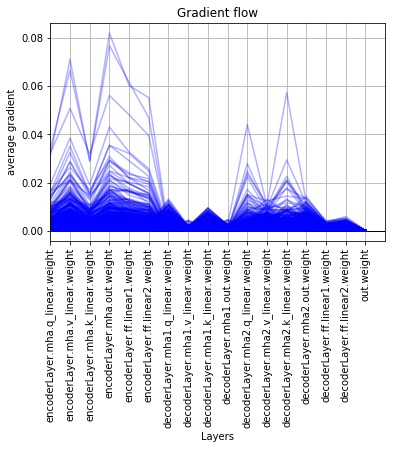

In [30]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model=EndtoEnd(512,2048,0.1,8,vocab.num_words,max_length)
model.cuda()
torch.set_default_tensor_type('torch.cuda.FloatTensor')
plotter=VisdomLinePlotter('main')
for p in model.parameters():
    if p.dim()>1:
        nn.init.xavier_uniform_(p)
run_epoch(p_context,p_knowledge,p_wizard,vocab.num_words,model)